In [2]:
!nvidia-smi

Sun Feb  9 23:36:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P8             13W /  170W |     799MiB /  12288MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from pathlib import Path
data_dir = Path("C:/Users/Raphael/Dev/data_science/libras")

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

train_dir, test_dir

(WindowsPath('C:/Users/Raphael/Dev/data_science/libras/train'),
 WindowsPath('C:/Users/Raphael/Dev/data_science/libras/test'))

In [73]:
from torchvision.transforms import v2
import random
from PIL import Image

image_path_list = list(data_dir.glob('*/*/*.png'))

random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(128, 128), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
])


transformed_image = transforms(img).permute(1, 2, 0)
transformed_image.shape

torch.Size([128, 128, 3])

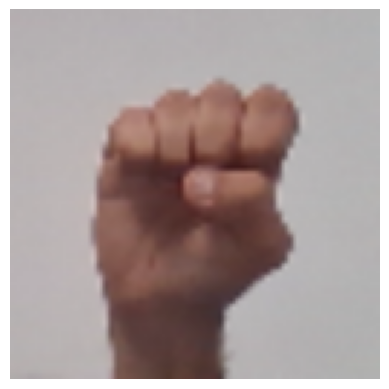

In [74]:
import matplotlib.pyplot as plt

plt.imshow(transformed_image)
plt.axis('off')
plt.show()